In [1]:
from fastai.basics import *
#from fastai.vision import *
from fastai.callback import *
from PIL import Image as Image
from fastai.optimizer import ranger
from torchvision.models.resnet import resnet34
#from fastai.vision import unet_learner
from fastai.vision.all import *
from fastai.vision.data import *
from fastai.vision.learner import *
from fastai.vision.models import *
from fastai.data.transforms import *

In [2]:
path_ = 'E:/KHA240214/segmentstion_task/Reham/images/'#

path_im = path_+'new_img'
path_lbl = path_+'new_binary'
model_path = path_+'/models/'

# collecting train and validation images
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

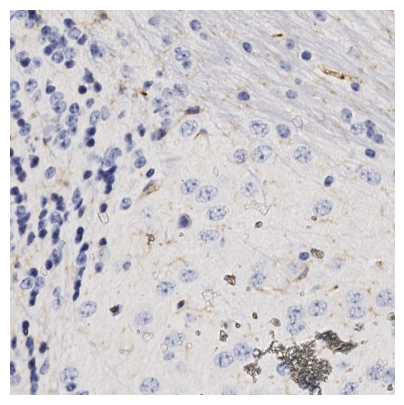

In [3]:
img_fn = fnames[10]
img = Image.open(img_fn)
#img.show()
ax = show_image(img, cmap='Greys')

<Axes: >

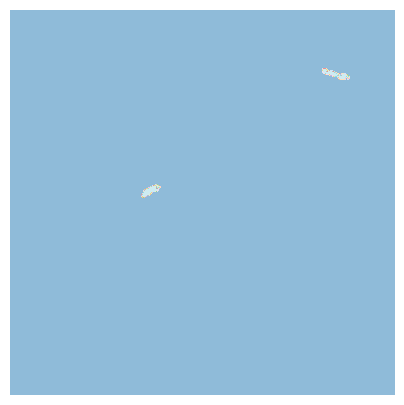

In [4]:
#label fundtion:get_msk
get_msk = lambda o: path_+'/new_binary/'+o.stem+'.png'
mask = PILMask.create(get_msk(img_fn))
mask.show(figsize=(5,5))

In [5]:
codes = np.loadtxt(f'{path_}code.txt', dtype=str)
codes

array(['BG', 'Cell'], dtype='<U4')

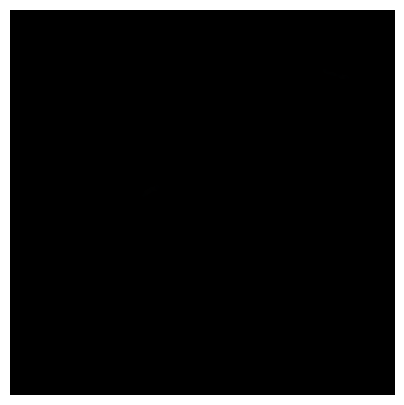

In [6]:
#label fundtion: get_y_fn
def get_y_fn(x):
    BB = path_lbl + "/" + x.stem + '.png'
    return BB

img_f = fnames[10]
mask = get_y_fn(img_f)
mask = Image.open(mask)
#mask.show()
ax = show_image(mask, cmap='Grays')

In [7]:
src_size = np.array(mask.shape)
src_size = tuple(int(x/2) for x in src_size)
src_size

(256, 256)

In [8]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [9]:
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['BG']

{'BG': 0, 'Cell': 1}


In [10]:
def MeanIOU(input:Tensor, targs:Tensor, iou:bool=True):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return 2. * intersect / union
    else: return intersect / (union-intersect+1.0)

In [11]:
default_device = torch.device("cuda:0")
print(torch.cuda.is_available())
default_device

True


device(type='cuda', index=0)

In [12]:
tfms = aug_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.2)

In [13]:
#dls = SegmentationDataLoaders.from_label_func(path_, fnames, get_y_fn, valid_pct=0.2, codes=codes, bs=4, device=default_device, batch_tfms=tfms)
dls = SegmentationDataLoaders.from_label_func(path_, fnames, get_y_fn, valid_pct=0.2,
                                      codes=codes, bs=4, 
                                      batch_tfms=tfms,
                                      device=default_device)

In [14]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

weights = torch.tensor([1., 2.]).to(device=default_device)
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)


In [15]:
#weights = torch.tensor([[0.9]*31 + [1.1]]).cuda()
weights.shape
weights

tensor([1., 2.], device='cuda:0')

In [16]:
wd = 1e-4
lr = 1E-4
opt = ranger
ls_func = DiceLoss(reduction='mean')
#ls_func.require_grad_ = True
#optm = Adam(models.resnet34, lr=lr, sqr_mom=0.99, eps=1e-08, wd=wd)
learn = unet_learner(dls, models.resnet34, pretrained=True, n_out=None,
                     metrics=MeanIOU, wd=wd, loss_func=ls_func,
                     y_range=(0,1), 
                     lr = lr, #splitter=FileSplitter('./valid.txt'),
                     self_attention=True, opt_func=Adam,
                     )
#learn.requires_grad_ =True
#.to_fp16()
#learn = unet_learner(data, models.resnet18, metrics=MeanIOU, wd=wd,  callback_fns=ShowGraph).to_fp16()


In [17]:
learn.load(f'{model_path}241008_saved_segmentation_model_ep120_mIoU40_with new data')

In [18]:
torch.cuda.empty_cache()

SuggestedLRs(valley=0.004365158267319202)

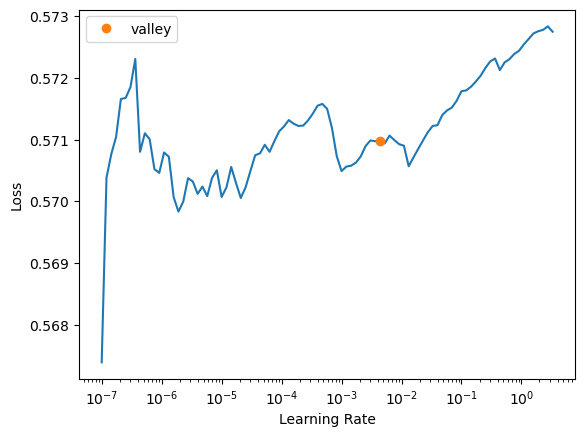

In [38]:
learn.lr_find()

In [19]:
lr = 1e-4
learn.fit(20, slice(lr, lr/1e5), start_epoch = 0, wd=1e-8)

epoch,train_loss,valid_loss,MeanIOU,time
0,0.571245,0.569501,0.383755,00:53
1,0.571454,0.569518,0.384405,00:46
2,0.571425,0.569520,0.386736,00:46
3,0.571485,0.569586,0.377206,00:46
4,0.571408,0.569530,0.384305,00:46
5,0.571415,0.569555,0.385546,00:46
6,0.571371,0.569540,0.377051,00:50
7,0.571386,0.569564,0.376915,00:49
8,0.571355,0.569541,0.385264,00:48
9,0.571293,0.569495,0.387969,00:50


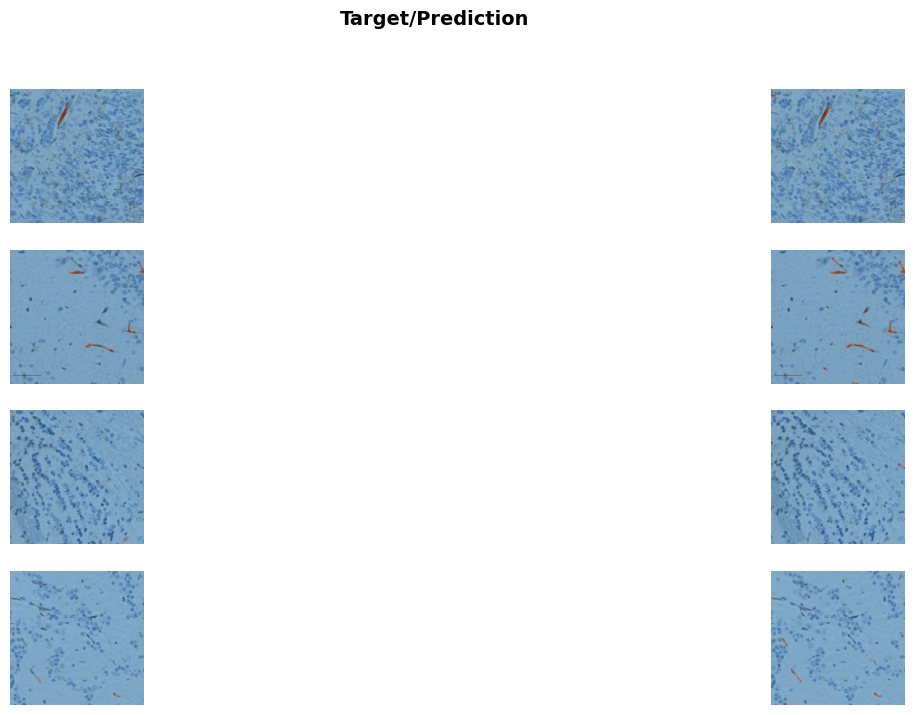

In [21]:
learn.show_results(max_n=4, figsize=(18,8))

In [22]:
lr = 1e-4
learn.fit(100, slice(lr, lr/1e5), start_epoch = 0, wd=1e-8)

epoch,train_loss,valid_loss,MeanIOU,time
0,0.571372,0.569509,0.387155,00:48
1,0.571541,0.569501,0.365846,00:47
2,0.571260,0.569482,0.388970,00:48
3,0.571371,0.569471,0.396360,00:49
4,0.571772,0.569483,0.375669,00:49
5,0.571543,0.569518,0.393268,00:50
6,0.571505,0.569548,0.382281,00:52
7,0.571724,0.569519,0.380477,00:51
8,0.571553,0.569499,0.385344,00:51
9,0.571886,0.569526,0.376713,00:52


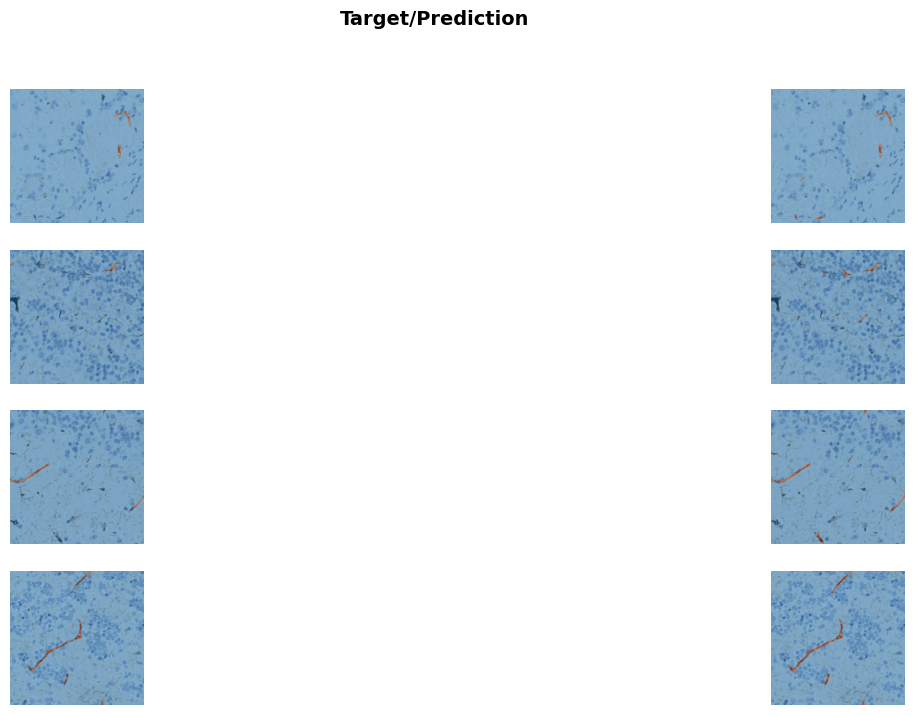

In [23]:
learn.show_results(max_n=4, figsize=(18,8))

In [24]:
learn.save('241008_saved_segmentation_model_ep120_mIoU40_with new data')

Path('E:/KHA240214/segmentstion_task/Reham/images/models/241008_saved_segmentation_model_ep120_mIoU40_with new data.pth')

In [38]:
#generating binary result
path_test = 'E:/KHA240214/Reham/PT+PBM 28_CD31/test2/'
for folder in os.listdir(path_test):
    fnames_test = get_image_files(f'{path_test}{folder}')
    dl2 = learn.dls.test_dl(fnames_test)
    preds = learn.get_preds(dl=dl2)

    for i in range(len(fnames_test)):
        _p, _n = os.path.split(fnames_test[i])
        sav_name = _n.split('.jpg')[0]+'_binary.png'

        pred1 = preds[0][i]
        pred_arx = (pred1.argmax(dim=0)).numpy()
        rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)#plt.imshow(pred_arx)
        im.save(os.path.join(f'{_p}/{sav_name}'))


C:\Users\NPL_GPU\AppData\Local\Temp\ipykernel_1816\3861888818.py:14: RuntimeWarning: divide by zero encountered in divide
  rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)
C:\Users\NPL_GPU\AppData\Local\Temp\ipykernel_1816\3861888818.py:14: RuntimeWarning: invalid value encountered in multiply
  rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)
C:\Users\NPL_GPU\AppData\Local\Temp\ipykernel_1816\3861888818.py:14: RuntimeWarning: invalid value encountered in cast
  rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)


In [18]:
import PIL.ImageOps as ops
import PIL.Image as Image
import cv2

In [39]:
#reassembling and overlapping
test_path = 'E:/KHA240214/Reham/PT+PBM 28_CD31/test2/'
whole_im_p = 'E:/KHA240214/Reham/PT+PBM 28_CD31/CD31'

for foldername in os.listdir(test_path):
        print(foldername) 
        org_im = Image.open(f'{whole_im_p}/{foldername}.png')
        H, W = org_im.shape
        new_org_im = Image.new('RGB', (W, H))
        new_org_gr = Image.new('L', (W, H))
             
        for images in glob.glob(f'{test_path}{foldername}/*.jpg'):
            print(images)
            crp_im = Image.open(images)
            crp_im_ar = np.array(crp_im)
            #crp_im_ar = cv2.imread(images)
            crp_pth, crp_name = os.path.split(images)
            mask_name = os.path.join(crp_pth, crp_name.split('.jpg')[0]) + '_binary.png'
            x, y = int(crp_name.split('.jpg')[0].split('_')[2]), int(crp_name.split('.jpg')[0].split('_')[3])
            #print(crp_name, crp_name.split('.jpg')[0])
            mask = Image.open(mask_name)
            mask_ar = np.array(mask)#.resize((tst_im_gr.shape[1], tst_im_gr.shape[0])))
            #mask_ar = cv2.imread(mask_name)
            print(mask_ar.shape, crp_im_ar.shape)
             
            crp_im_ar[:,:,0] = crp_im_ar[:,:,0] + 0.3*mask_ar[:,:]*200  # increasing the color more
            new_org_im.paste(Image.fromarray(crp_im_ar), (y, x))
            new_org_gr.paste(Image.fromarray(mask_ar), (y, x))

        new_org_im.save(f'{whole_im_p}/{foldername}_overlap.jpg')
        new_org_gr.save(f'{whole_im_p}/{foldername}_mask.jpg')

CD31_C1#1
E:/KHA240214/Reham/PT+PBM 28_CD31/test2/CD31_C1#1\CD31_C1#1_0_0.jpg
(512, 512) (512, 512, 3)
E:/KHA240214/Reham/PT+PBM 28_CD31/test2/CD31_C1#1\CD31_C1#1_0_1024.jpg
(512, 512) (512, 512, 3)
E:/KHA240214/Reham/PT+PBM 28_CD31/test2/CD31_C1#1\CD31_C1#1_0_1536.jpg
(512, 512) (512, 512, 3)
E:/KHA240214/Reham/PT+PBM 28_CD31/test2/CD31_C1#1\CD31_C1#1_0_1673.jpg
(512, 512) (512, 512, 3)
E:/KHA240214/Reham/PT+PBM 28_CD31/test2/CD31_C1#1\CD31_C1#1_0_512.jpg
(512, 512) (512, 512, 3)
E:/KHA240214/Reham/PT+PBM 28_CD31/test2/CD31_C1#1\CD31_C1#1_512_0.jpg
(512, 512) (512, 512, 3)
E:/KHA240214/Reham/PT+PBM 28_CD31/test2/CD31_C1#1\CD31_C1#1_512_1024.jpg
(512, 512) (512, 512, 3)
E:/KHA240214/Reham/PT+PBM 28_CD31/test2/CD31_C1#1\CD31_C1#1_512_1536.jpg
(512, 512) (512, 512, 3)
E:/KHA240214/Reham/PT+PBM 28_CD31/test2/CD31_C1#1\CD31_C1#1_512_1673.jpg
(512, 512) (512, 512, 3)
E:/KHA240214/Reham/PT+PBM 28_CD31/test2/CD31_C1#1\CD31_C1#1_512_512.jpg
(512, 512) (512, 512, 3)
E:/KHA240214/Reham/PT+PBM 28

In [47]:
px_in1mm = 2200 # 1 mm^2 is 2200 pixels; 50um = 110px
px_ = 1/px_in1mm # in mm # 1 px = (1/2200) mm = (1000/2200) um
px_area = px_ * px_ # 1 px area = (1000/2200) um * (1000/2200) um =_____ um^2
                    # 1 px area = (1/2200) mm x (1/2200) mm = __________ mm^2 
dict = {'Type':[], 'Image_name':[], 'Image_area (pixels)': [],'Image_area (mm^2)': [], 'Cell_area (pixels)' : [], 'Cell_area (mm^2)' : []}

In [51]:

test_path = 'E:/KHA240214/Reham/PT 7_CD31/CD31'

for mask in glob.glob(f'{test_path}/*.png'):
    mask_name = mask.split('.png')[0]+'_mask.jpg'
    mask_im = cv2.imread(mask_name)
    mask_gr = cv2.cvtColor(mask_im, cv2.COLOR_RGB2GRAY)
    whole_im_mm = np.round(mask_gr.size * px_area, 6)  # mask size in mm^2
    cell_area_px = np.sum(mask_im==255)
    cell_area_mm = np.round(cell_area_px * px_area, 6)   # cell area in mm^2

    dict['Type'].append('PT 7_CD31')
    dict['Image_name'].append(mask)
    dict['Image_area (pixels)'].append(mask_gr.size)
    dict['Image_area (mm^2)'].append(whole_im_mm)
    dict['Cell_area (pixels)'].append(cell_area_px)
    dict['Cell_area (mm^2)'].append(cell_area_mm)
    
    print(f'{mask}: whole_imaeh: {whole_im_mm} mm^2, cell_area: {cell_area_mm} mm^2' )



E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A10#1.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.004143 mm^2
E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A10#2.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.006759 mm^2
E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A10#3.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.007483 mm^2
E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A10#4.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.002532 mm^2
E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A10#5.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.002657 mm^2
E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A10#6.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.003203 mm^2
E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A6#1.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.016538 mm^2
E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A6#2.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.012351 mm^2
E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A6#3.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.01395 mm^2
E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A6#4.png: whole_imaeh: 0.626948 mm^2, 

In [54]:
import pandas as pd
df = pd.DataFrame(dict)
df.to_excel('241008_Cellarea_calc_result_KHA_RAS.xlsx')

In [40]:
110*1e3/50

2200.0

In [57]:
listname = ['PT 7_CD31', 'PT 28_ CD31', 'PT+PBM 7_ CD31', 'PT+PBM 28_CD31']
dict = {}

px_in1mm = 2200 # 1 mm^2 is 2200 pixels; 50um = 110px
px_ = 1/px_in1mm # in mm # 1 px = (1/2200) mm = (1000/2200) um
px_area = px_ * px_ # 1 px area = (1000/2200) um * (1000/2200) um =_____ um^2
                    # 1 px area = (1/2200) mm x (1/2200) mm = __________ mm^2 

for type in listname:
    dict[f'{type}wholearea_px'] = []
    dict[f'{type}wholearea_mm2'] = []
    dict[f'{type}cellarea_px'] = []
    dict[f'{type}cellarea_mm2'] = []
    dict[f'{type}density_px'] = []
    dict[f'{type}density_mm2'] = []

for type in listname:
    test_path = f'E:/KHA240214/Reham/{type}/CD31'
    for mask in glob.glob(f'{test_path}/*.png'):
        mask_name = mask.split('.png')[0]+'_mask.jpg'
        mask_im = cv2.imread(mask_name)
        mask_gr = cv2.cvtColor(mask_im, cv2.COLOR_RGB2GRAY)
        whole_im_mm = np.round(mask_gr.size * px_area, 6)  # mask size in mm^2
        cell_area_px = np.sum(mask_im==255)
        cell_area_mm = np.round(cell_area_px * px_area, 6)   # cell area in mm^2

        dict[f'{type}wholearea_px'].append(mask_gr.size)
        dict[f'{type}wholearea_mm2'].append(whole_im_mm)
        dict[f'{type}cellarea_px'].append(cell_area_px)
        dict[f'{type}cellarea_mm2'].append(cell_area_mm)
        dict[f'{type}density_px'].append(cell_area_px/mask_gr.size)
        dict[f'{type}density_mm2'].append(cell_area_mm/whole_im_mm)
    
    print(f'{mask}: whole_imaeh: {whole_im_mm} mm^2, cell_area: {cell_area_mm} mm^2' )

df = pd.DataFrame(dict)
df.to_excel('241008_Cellarea_calc_result_KHA_RAS2.xlsx')



E:/KHA240214/Reham/PT 7_CD31/CD31\CD31_A9#6.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.006997 mm^2
E:/KHA240214/Reham/PT 28_ CD31/CD31\CD31_C9#6.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.01215 mm^2
E:/KHA240214/Reham/PT+PBM 7_ CD31/CD31\CD31_A5#6.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.001651 mm^2
E:/KHA240214/Reham/PT+PBM 28_CD31/CD31\CD31_C5#6.png: whole_imaeh: 0.626948 mm^2, cell_area: 0.010689 mm^2


In [58]:
df.head(3)

,PT 7_CD31wholearea_px,PT 7_CD31wholearea_mm2,PT 7_CD31cellarea_px,PT 7_CD31cellarea_mm2,PT 7_CD31density_px,PT 7_CD31density_mm2,PT 28_ CD31wholearea_px,PT 28_ CD31wholearea_mm2,PT 28_ CD31cellarea_px,PT 28_ CD31cellarea_mm2,...,PT+PBM 7_ CD31cellarea_px,PT+PBM 7_ CD31cellarea_mm2,PT+PBM 7_ CD31density_px,PT+PBM 7_ CD31density_mm2,PT+PBM 28_CD31wholearea_px,PT+PBM 28_CD31wholearea_mm2,PT+PBM 28_CD31cellarea_px,PT+PBM 28_CD31cellarea_mm2,PT+PBM 28_CD31density_px,PT+PBM 28_CD31density_mm2
0,3034430,0.626948,20052,0.004143,0.006608,0.006608,3034430,0.626948,2247,0.000464,...,17325,0.003580,0.004861,0.004862,2722510,0.562502,11778,0.002433,0.004326,0.004325
1,3034430,0.626948,32715,0.006759,0.010781,0.010781,3034430,0.626948,2052,0.000424,...,13026,0.002691,0.003655,0.003654,3034430,0.626948,10359,0.002140,0.003414,0.003413
2,3034430,0.626948,36216,0.007483,0.011935,0.011936,3034430,0.626948,1302,0.000269,...,14838,0.003066,0.004163,0.004164,3034430,0.626948,7254,0.001499,0.002391,0.002391


Text(0.5, 1.0, 'Mean Values of 4 Classes with p-value from ANOVA')

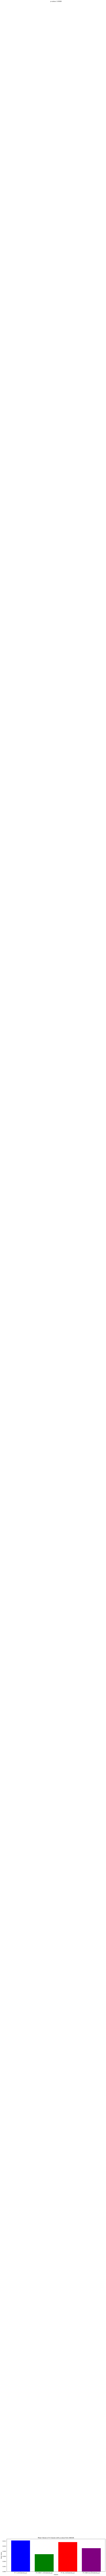

In [69]:
from scipy import stats
import matplotlib.pyplot as plt

# Sample data for four groups
class1 = df['PT 7_CD31density_px']
class2 = df['PT+PBM 7_ CD31density_px']
class3 = df['PT 28_ CD31density_px']
class4 = df['PT+PBM 28_CD31density_px']


data = [class1, class2, class3, class4]

# Perform ANOVA
F_statistic, p_value = stats.f_oneway(class1, class2, class3, class4)

means = [np.mean(class1), np.mean(class2), np.mean(class3), np.mean(class4)]
labels = ['PT 7_CD31density_px', 'PT+PBM 7_ CD31density_px', 'PT 28_ CD31density_px', 'PT+PBM 28_CD31density_px']

#print("F-statistic:", F_statistic)
#print("p-value:", p_value)

plt.figure(figsize=(15, 5))
bars = plt.bar(labels, means, color=['blue', 'green', 'red', 'purple'])
# Annotating the p-value on the plot
plt.text(1.5, max(means) + 1, f'p-value: {p_value:.4f}', fontsize=12, ha='center')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Mean Value')
plt.title('Mean Values of 4 Classes with p-value from ANOVA')

# Optional: Add a grid
#plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
#plt.show()